# Fit missing-mass squared distributions

In [1]:
# on ifarm, use Python 3.6.8
import array

import numpy as np
import ROOT
from pathvalidate import sanitize_filename, sanitize_filepath
from uncertainties import ufloat
from uncertainties.umath import *

import fitFunction  # defines fit function: double Gaussian on top of a 2nd-order polynomial
import makePlots    # defines helper functions to generate histograms from data trees

makePlots.setupPlotStyle()

Welcome to JupyROOT 6.26/10


Info in <TMacOSXSystem::ACLiC>: creating shared library /Users/bgrube/GlueX/Analysis/ProtonTrackEfficiency/trackingEfficiency/././doubleGaussianPol2_C.so


## Define parameters and load input data

In [2]:
# selection         = "paul"
selection         = "justin"
# particle          = "Pi-"
# particle          = "Pi+"
particle          = "Proton"
# channel           = "2pi"
channel           = "4pi"
# dataset           = "30370_acc_Pval"
dataset           = "bggen_2017_01-ver03"
# if selection == "paul":
#   inFileName = f"../pmatt/trackeff_{particle}_{channel}{f'.{dataset}' if dataset != '' else ''}.root"
# elif selection == "justin":
#   inFileName = f"../ReactionEfficiency/pippippimpimpmiss_bggen_2017_01-ver03.root"
# else:
#   raise ValueError(f"Unknown selection '{selection}'")
treeFileName      = "../ReactionEfficiency/pippippimpimpmiss_flatTree_bggen_2017_01-ver03.root"
treeName          = "pippippimpimpmiss"

additionalFilter  = None
pdfFileNameSuffix = ""
# additionalFilter  = '(ThrownTopology.GetString() == "2#pi^{#plus}2#pi^{#minus}p")'
# pdfFileNameSuffix = "__sig"
# additionalFilter  = '(ThrownTopology.GetString() == "2#gamma2#pi^{#plus}2#pi^{#minus}p[#pi^{0}]")'
# pdfFileNameSuffix = "__2#gamma2#pi^{#plus}2#pi^{#minus}p[#pi^{0}]"
# additionalFilter  = '(ThrownTopology.GetString() != "2#pi^{#plus}2#pi^{#minus}p")'
# pdfFileNameSuffix = "__bkg"
# additionalFilter  = "(NmbUnusedShowers == 0)"
# pdfFileNameSuffix = "__noUnusedShowers"

mm2HistDef        = {
  "variables"      : ("MissingMassSquared_Measured",),
  "axisTitles"     : "(#it{m}^{miss}_{measured})^{2} (GeV/c^{2})^{2}",
  "binning"        : (250, -0.5, 4.5),
  "weightVariable" : "AccidWeightFactor"
}
fitRange          = (-0.5, 4)
beamEnergyRange   = (3.0, 12.0)  # [GeV]
nmbBeamEnergyBins = 9            # 1 GeV bin width
markerSize        = 0.75

ROOT.EnableImplicitMT()   # activate implicit multi-threading for RDataFrame
inputData = ROOT.RDataFrame(treeName, treeFileName)
ROOT.DisableImplicitMT()  # NOTE! enabling multithreading via ROOT.EnableImplicitMT() sends Minuit into an infinite loop (on ROOT 6.24/04 (ifarm) and 6.26/10)

## Tracking efficiency from overall missing-mass squared distributions

### Get overall missing-mass squared distributions by projecting the 2D histograms and adjust binning

Info in <TCanvas::Print>: pdf file ./justin_Proton_4pi_bggen_2017_01-ver03_mm2_Total__sig.pdf has been created
Info in <TCanvas::Print>: pdf file ./justin_Proton_4pi_bggen_2017_01-ver03_mm2_Found__sig.pdf has been created
Info in <TCanvas::Print>: pdf file ./justin_Proton_4pi_bggen_2017_01-ver03_mm2_Missing__sig.pdf has been created


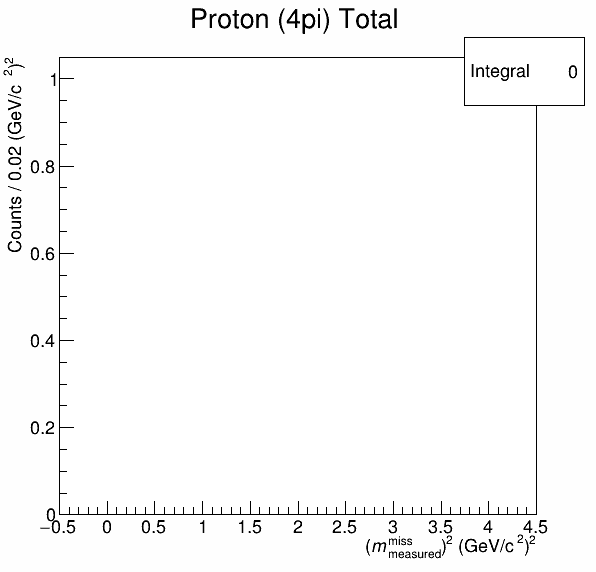

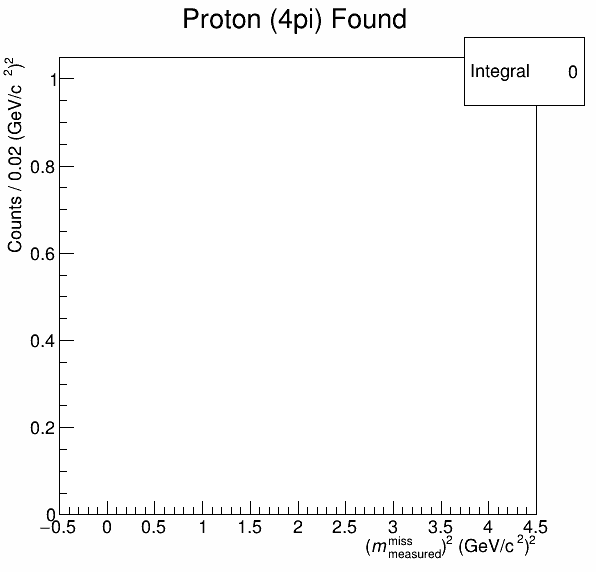

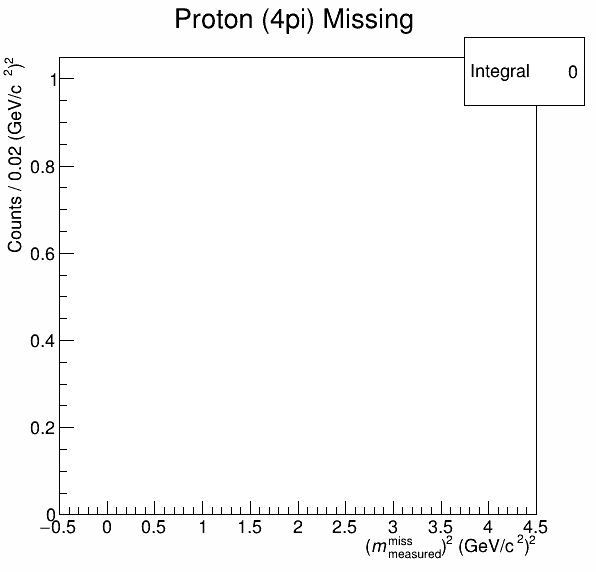

In [3]:
ROOT.EnableImplicitMT()
MM2Hists = {}
for case, caseFilter in makePlots.FILTER_CASES.items():
  caseData = inputData.Filter(caseFilter)
  MM2Hists[case] = makePlots.getHistND(caseData, **mm2HistDef, filterExpression = additionalFilter,
    histNameSuffix = case, histTitle = f"{particle} ({channel}) {case}")
# MM2Hists = {case : inFile.Get("MissingMassSquared/MissingMassSquared" + ("" if case == "Total" else "_" + case)) for case in ["Total", "Found", "Missing"]}
# MM2Hists = {case : inFile.Get("MissingMassSquared/MissingMassSquared" + ("" if case == "Total" else "_" + case) + "__2#pi^{#plus}2#pi^{#minus}p") for case in ["Total", "Found", "Missing"]}
# MM2Hists = {case : inFile.Get("MissingMassSquared/MissingMassSquared" + ("" if case == "Total" else "_" + case) + "__2#gamma2#pi^{#plus}2#pi^{#minus}p[#pi^{0}]") for case in ["Total", "Found", "Missing"]}
canvs = []
for case, MM2Hist in MM2Hists.items():
  canv = ROOT.TCanvas(sanitize_filename(f"{selection}_{particle}_{channel}_{dataset}_mm2_{case}{pdfFileNameSuffix}"), "")
  MM2Hist.Draw("HIST")
  MM2Hist.SetYTitle(f"Counts / {MM2Hist.GetBinWidth(1)} (GeV/c^{{2}})^{{2}}")
  canv.Draw()
  canv.SaveAs(".pdf")
  canvs.append(canv)
ROOT.DisableImplicitMT()

### Fit missing-mass squared distributions for the 3 cases

In [4]:
fitResults = {case : fitFunction.fitDistribution(MM2Hist, particle, fitRange, forceCommonGaussianMean = False) for (case, MM2Hist) in MM2Hists.items()}

Fitting histogram 'MissingMassSquared_Measured_Total', 'Proton (4pi) Total'.


ReferenceError: attempt to access a null-pointer

Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S


In [ ]:
def fitStatusString(fitResult):
  return (
    f"minimizer status = {fitResult.Status()}, "
    f"fit result is valid = {fitResult.IsValid()}, "
    f"covariance matrix status = {fitFunction.COV_MATRIX_STATUS_CODE[fitResult.CovMatrixStatus()][1]}"
  )

Show fit result

In [ ]:
canvsOverall = {}
for case, MM2Hist in MM2Hists.items():
  canvsOverall[case] = ROOT.TCanvas(sanitize_filename(f"{selection}_{particle}_{channel}_{dataset}_mm2_fit_{case}{pdfFileNameSuffix}"), "")
  MM2Hist.Draw()
  canvsOverall[case].Update()  # needed otherwise TPaveStats object is not created
  stats = MM2Hist.FindObject("stats")
  stats.SetX1NDC(0.65)
  stats.SetX2NDC(0.98)
  stats.SetY1NDC(0.3)
  stats.SetY2NDC(0.92)
  canvsOverall[case].Draw()
  canvsOverall[case].SaveAs(".pdf")
for case, fitResult in fitResults.items():
  print(f"{case}: {fitStatusString(fitResult)}")

### Get overall signal yields and calculate average efficiency

In [ ]:
def getFitParameter(fitResult, parName):
  parIndex = fitResult.Index(parName)
  return ufloat(fitResult.Parameter(parIndex), fitResult.ParError(parIndex))

In [ ]:
def getSignalYield(fitResult):
  return getFitParameter(fitResult, "A")

In [ ]:
def calculateEfficiency(fitResults):  # dictionary with TFitResults for "Total", "Found", and "Missing"
  signalYields = {case : getSignalYield(fitResult) for (case, fitResult) in fitResults.items()}
  return signalYields["Found"] / (signalYields["Found"] + signalYields["Missing"])

In [ ]:
signalYields = {case : getSignalYield(fitResult) for (case, fitResult) in fitResults.items()}
overallEff = calculateEfficiency(fitResults)
#TODO one could perform a combined fit of all 3 histograms enforcing Found + Missing == Total
print(signalYields, f"mismatch = {100 * (signalYields['Total'] - signalYields['Found'] - signalYields['Missing']) / signalYields['Total']}%")
print(f"Overall efficiency = {100 * overallEff}%")
# {'Total': 1873153.5428730857+/-2973.1052778913872, 'Found': 973390.6673264182+/-1547.0396174425841, 'Missing': 939329.6803516215+/-3532.4453758962336} mismatch = -2.11+/-0.26%
# Overall efficiency = 50.89+/-0.10%

## Tracking efficiencies as a function of beam energy from missing-mass squared distributions

### Fit missing-mass squared distributions in bins of beam energy

In [ ]:
ROOT.EnableImplicitMT()
minCounts = 1000  # minimum number of counts required in energy bin
MM2HistsEBins = {}
energyBinWidth = (beamEnergyRange[1] - beamEnergyRange[0]) / float(nmbBeamEnergyBins)
for case, caseFilter in makePlots.FILTER_CASES.items():
  caseData = inputData.Filter(caseFilter)
  MM2HistsEBins[case] = {}
  for energyBin in range(nmbBeamEnergyBins):
    energyBinMin = beamEnergyRange[0] + energyBin * energyBinWidth
    energyBinMax = energyBinMin + energyBinWidth
    energyFilter = f"(({energyBinMin} < BeamEnergy) and (BeamEnergy < {energyBinMax}))"
    energyBinData = caseData.Filter(energyFilter)
    MM2Hist = makePlots.getHistND(energyBinData, **mm2HistDef, filterExpression = additionalFilter,
      histNameSuffix = f"Egamma_{energyBinMin}_{energyBinMax}_{case}",
      histTitle = f"{particle} ({channel}) {case}, {energyBinMin} < E_{{#gamma}} (GeV) < {energyBinMax}")
    MM2Hist.Draw()
    MM2Hist.SetYTitle(f"Counts / {MM2Hist.GetBinWidth(1)} (GeV/c^{{2}})^{{2}}")
    counts = MM2Hist.Integral(1, MM2Hist.GetNbinsX())
    if counts >= minCounts:
      MM2HistsEBins[case][(energyBinMin, energyBinMax)] = MM2Hist
    else:
      print(f"Warning: {counts} counts in beam energy bin {(energyBinMin, energyBinMax)} are below the required minimum of {minCounts}. Skipping bin.")
ROOT.DisableImplicitMT()

In [ ]:
def fitMissingMassSquaredBeamEnergyBins(
  MM2HistsEBins,  # dictionary of dictionaries {case : {energy bin : histogram, ...}, ...}
  **kwargs
):
  fitResults = {}
  for case, MM2Hists in MM2HistsEBins.items():
    fitResults[case] = {}
    for energyBin, MM2Hist in MM2Hists.items():
      # fit distribution
      print(f"Fitting case {case} for beam energy bin {energyBin} GeV")
      fitResults[case][energyBin] = fitFunction.fitDistribution(MM2Hist, **kwargs)

  return fitResults

In [ ]:
fitResultsEBins = fitMissingMassSquaredBeamEnergyBins(MM2HistsEBins, particle = particle, fitRange = fitRange, forceCommonGaussianMean = True)

### Check whether fits converged

In [ ]:
for case, fitResults in fitResultsEBins.items():
  for energyBin, fitResult in fitResults.items():
    print(f"case {case}, energy bin {energyBin} GeV: {fitStatusString(fitResult)}")

### Show fits

In [ ]:
canvsEBins = {}
for case, MM2Hists in MM2HistsEBins.items():
  canvsEBins[case] = {}
  for energyBin, MM2Hist in MM2Hists.items():
    canvsEBins[case][energyBin] = ROOT.TCanvas(sanitize_filename(f"{selection}_{particle}_{channel}_{dataset}_mm2_Egamma_{energyBin[0]}_{energyBin[1]}_fit_{case}{pdfFileNameSuffix}"), "")
    MM2Hist.SetMinimum(0)
    MM2Hist.Draw()
    canvsEBins[case][energyBin].Update()  # needed otherwise TPaveStats object is not created
    stats = MM2Hist.FindObject("stats")
    stats.SetX1NDC(0.58)
    stats.SetX2NDC(0.98)
    stats.SetY1NDC(0.28)
    stats.SetY2NDC(0.93)
    canvsEBins[case][energyBin].Draw()
    canvsEBins[case][energyBin].SaveAs(".pdf")

### Plot fit parameters

Get values of fit parameters

In [ ]:
fitParValues = {}  # {case : {parameter name : [ [energy bin center, parameter value] ...] ...} ...}
for case in fitResultsEBins.keys():
  fitParValues[case] = {}
  for energyBin, fitResult in fitResultsEBins[case].items():
    energyBinCenter = (energyBin[0] + energyBin[1]) / 2
    for parIndex in range(fitResult.NTotalParameters()):
      parName = fitResult.ParName(parIndex)
      parValue = getFitParameter(fitResult, parName)
      if not parName in fitParValues[case]:
        fitParValues[case][parName] = []
      fitParValues[case][parName].append([energyBinCenter, parValue])
    parName  = "#chi^{2}/ndf"
    parValue = ufloat(fitResult.Chi2() / fitResult.Ndf(), 0)
    if not parName in fitParValues[case]:
      fitParValues[case][parName] = []
    fitParValues[case][parName].append([energyBinCenter, parValue])
# print(fitParValues)

Postprocess fit-parameter values

In [ ]:
for case in fitParValues.keys():
  for energyBinIndex, r in enumerate(fitParValues[case]["r"]):
    # calculate Gaussian 2 fraction
    ratio = sin(r[1])**2
    # make sure sigma_1 is the narrow Gaussian
    sigma1 = fitParValues[case]["#sigma_{1}"][energyBinIndex][1]
    sigma2 = fitParValues[case]["#sigma_{2}"][energyBinIndex][1]
    if sigma1 > sigma2:
      # print("!!!swap")
      # swap values
      fitParValues[case]["#sigma_{1}"][energyBinIndex][1] = sigma2
      fitParValues[case]["#sigma_{2}"][energyBinIndex][1] = sigma1
      #TODO add case for separate mean values
      ratio = 1 - ratio
    # print(energyBinIndex, ratio)
    fitParValues[case]["r"][energyBinIndex][1] = ratio
# print(fitParValues)

Plot fit-parameter values

In [ ]:
caseColors = {
  "Total"   : ROOT.kBlack,
  "Found"   : ROOT.kGreen + 2,
  "Missing" : ROOT.kRed + 1}
energyOffsets = {
  "Total"   : 0,
  "Found"   : 0.1,
  "Missing" : 0.05}
canvsFitPar = []
parValueMultiGraphs = []
parValueGraphs = []
for parName in fitParValues["Total"].keys():
  canvsFitPar.append(ROOT.TCanvas(sanitize_filename(f"{selection}_{particle}_{channel}_{dataset}_mm2_fitpar_{parName}{pdfFileNameSuffix}"), ""))
  parValueMultiGraphs.append(ROOT.TMultiGraph())
  parValueGraphs.append({})
  for case in fitParValues.keys():
    parValues = fitParValues[case][parName]
    xVals = array.array('d', [energy + energyOffsets[case] for energy, _ in parValues])
    yVals = array.array('d', [parValue.nominal_value for _, parValue in parValues])
    yErrs = array.array('d', [parValue.std_dev       for _, parValue in parValues])
    parValueGraphs[-1][case] = ROOT.TGraphErrors(len(xVals), xVals, yVals, ROOT.nullptr, yErrs)
    graph = parValueGraphs[-1][case]
    graph.SetTitle(case)
    graph.SetMarkerStyle(ROOT.kFullCircle)
    graph.SetMarkerSize(markerSize)
    graph.SetMarkerColor(caseColors[case])
    graph.SetLineColor(caseColors[case])
    parValueMultiGraphs[-1].Add(graph)
  parValueMultiGraph = parValueMultiGraphs[-1]
  parValueMultiGraph.SetTitle(f"{particle} ({channel})")
  parValueMultiGraph.GetXaxis().SetTitle("Beam Energy (GeV)")
  parValueMultiGraph.GetYaxis().SetTitle(parName if parName != "r" else "Fraction Wide Gaussian")
  parValueMultiGraph.Draw("APZ")
  # canvsFitPar[-1].BuildLegend()  # crashes for unknown reason
  if parName == "#mu":
    parValueMultiGraph.SetMinimum(0.86)
    parValueMultiGraph.SetMaximum(1.11)
    # indicate nominal value m_p^2 value
    line = ROOT.TLine()
    line.SetLineStyle(ROOT.kDashed)
    protonMassSq = 0.93827208816**2
    line.DrawLine(parValueMultiGraph.GetXaxis().GetXmin(), protonMassSq, parValueMultiGraph.GetXaxis().GetXmax(), protonMassSq)
  if parName == "#chi^{2}/ndf":
    parValueMultiGraph.SetMinimum(0)
    parValueMultiGraph.SetMaximum(10)
    # indicate nominal value
    line = ROOT.TLine()
    line.SetLineStyle(ROOT.kDashed)
    line.DrawLine(parValueMultiGraph.GetXaxis().GetXmin(), 1, parValueMultiGraph.GetXaxis().GetXmax(), 1)
  canvsFitPar[-1].Draw()
  canvsFitPar[-1].SaveAs(".pdf")

### Calculate and plot efficiencies

In [ ]:
efficienciesEBins = {}
for energyBin in fitResultsEBins["Total"].keys():
  fitResults = {case : fitResultsEBins[case][energyBin] for case in fitResultsEBins.keys()}
  efficienciesEBins[energyBin] = calculateEfficiency(fitResults)
for energyBin, efficiency in efficienciesEBins.items():
  print(f"Efficiency in energy bin {energyBin} GeV = {100 * efficiency}%")
# Efficiency in energy bin (3.0, 4.0) GeV = 67.35+/-0.20%
# Efficiency in energy bin (4.0, 5.0) GeV = 62.32+/-0.24%
# Efficiency in energy bin (5.0, 6.0) GeV = 57.7+/-0.4%
# Efficiency in energy bin (6.0, 7.0) GeV = 53.91+/-0.31%
# Efficiency in energy bin (7.0, 8.0) GeV = 50.06+/-0.22%
# Efficiency in energy bin (8.0, 9.0) GeV = 47.92+/-0.11%
# Efficiency in energy bin (9.0, 10.0) GeV = 45.41+/-0.20%
# Efficiency in energy bin (10.0, 11.0) GeV = 43.95+/-0.26%
# Efficiency in energy bin (11.0, 12.0) GeV = 42.1+/-0.4%

In [ ]:

graphVals = [((energyBin[0] + energyBin[1]) / 2, efficiency) for (energyBin, efficiency) in efficienciesEBins.items()]
xVals = array.array('d', [graphVal[0]               for graphVal in graphVals])
yVals = array.array('d', [graphVal[1].nominal_value for graphVal in graphVals])
yErrs = array.array('d', [graphVal[1].std_dev       for graphVal in graphVals])
# print(xVals, yVals, yErrs)
efficienciesEBinsGraph = ROOT.TGraphErrors(len(graphVals), xVals, yVals, ROOT.nullptr, yErrs)
efficienciesEBinsGraph.SetTitle(f"{particle} Track-Finding Efficiency ({channel})")
efficienciesEBinsGraph.SetMarkerStyle(ROOT.kFullCircle)
efficienciesEBinsGraph.SetMarkerSize(markerSize)
efficienciesEBinsGraph.GetXaxis().SetTitle("Beam Energy (GeV)")
efficienciesEBinsGraph.GetYaxis().SetTitle("Efficiency")
efficienciesEBinsGraph.SetMinimum(0.55)
efficienciesEBinsGraph.SetMaximum(0.85)
canvEff = ROOT.TCanvas(sanitize_filename(f"{selection}_{particle}_{channel}_{dataset}_mm2_eff{pdfFileNameSuffix}"), "")
efficienciesEBinsGraph.Draw("AP")
# indicate value from fit of overall distributions
line = ROOT.TLine()
line.SetLineStyle(ROOT.kDashed)
line.DrawLine(efficienciesEBinsGraph.GetXaxis().GetXmin(), overallEff.nominal_value, efficienciesEBinsGraph.GetXaxis().GetXmax(), overallEff.nominal_value)
# indicate weighted average of efficiencies in energy bins
meanEff = np.average(yVals, weights = [1 / (yErr**2) for yErr in yErrs])
line.SetLineColor(ROOT.kRed + 1)
line.DrawLine(efficienciesEBinsGraph.GetXaxis().GetXmin(), meanEff, efficienciesEBinsGraph.GetXaxis().GetXmax(), meanEff)
canvEff.Draw()
canvEff.SaveAs(".pdf")

# Scratchpad

In [ ]:
# see https://root-forum.cern.ch/t/syntax-of-a-free-function-or-c-functor-for-tgraph-fitting/22292/3
# and https://root.cern/manual/python/#just-in-time-compilation-of-small-strings
ROOT.gInterpreter.ProcessLine('''
struct MyFunction {
  MyFunction() { }

  double operator() (double* vars, double* pars)
  {
    const double x  = vars[0];
    const double p0 = pars[0];
    const double p1 = pars[1];
    const double p2 = pars[2];

    const double linTerm = p1 + p2 * x;
    return p0 * p0 + linTerm * linTerm;
  }
};
''')
myFunc = ROOT.MyFunction()
func = ROOT.TF1("func", myFunc, -1, 1, 3)
# make function visible in Cling's global scope so it can be used in TFormula
# see https://root-forum.cern.ch/t/advanced-tformula-and-tf1-usage/36643/2
ROOT.gInterpreter.ProcessLine("TF1& func = *((TF1*)gROOT->GetFunction(\"func\"))")
#!!! parameter setting in TFormula expression does not work
fooFunc = ROOT.TF1("fooFunc", "func(x)", -1, 1, 3)
fooFunc.SetParameter(0, -1)
fooFunc.SetParameter(1, -2)
fooFunc.SetParameter(2, -3)
# fooFunc = ROOT.TF1("fooFunc", "func(x, [2..4])", -1, 1, 5)
# fooFunc.SetParameter(0, 10)
# fooFunc.SetParameter(1, -5)
# fooFunc.SetParameter(2, -1)
# fooFunc.SetParameter(3, -2)
# fooFunc.SetParameter(4, -3)
# canv = ROOT.TCanvas("canv", "", 800, 600)
fooFunc.Draw()
canv.Draw()